In [1]:
from covid_US import build_dynamic_network, find_clique_edges, SIR_model
import networkx as nx

import matplotlib
from matplotlib import pyplot as plt
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from networkx.drawing.nx_pylab import draw_networkx

import numpy as np
import glob
import pickle
import pandas as pd

In [2]:
matplotlib.rcParams["figure.figsize"] = [12, 10]

----------

#### network model parameters

- `social_dist_range`: time frame, within which social distancing restrictions are in effect
- `small_ent_range`: time frame, within which small enterprises are closed
- `large_ent_range`: time frame, within which large enterprises are closed


- `g`: static scale-free network to start from
- `number_of_iterations`: observed time frame
- `contact_duration`: all non-recurring contacts last this long
- `normal_contacts_lambda`: mean active/all contacts ratio in one iteration (drawn from an exponential distribution)
- `social_dist_contacts_lambda`: mean active/all contacts ratio in one iteration (drawn from an exponential distribution) within social distancing time frame
- `parties_lambda`: mean attendance ratio of parties (drawn from an exponential distribution)
- `contacts_threshold`: determines the max ratio of active contacts in one iteration
- `number_of_families`, `family_size`: number and size of complete subgraphs present during the entire observed time frame
- `small_ent_number`, `small_ent_size`: number and size of complete subgraphs present outside `small_ent_range`
- `large_ent_number`, `large_ent_size`: number and size of complete subgraphs present outside `large_ent_range`

-------------

#### SIR model parameters

- `g`: network to run simulation on
- `inf_0`: initial ratio of infected
- `beta`: transmission rate
- `gamma`: recovery rate

---------------

### build dynamic model

In [3]:
model_ID = "final"

In [4]:
name_dict = {
    i: n.format(model_ID)
    for i, n in enumerate(
        [
            "networks/network_{}",
            "model_results/model_{}",
            "model_results/iterations_{}",
            "model_results/trends_{}",
        ]
    )
}

In [5]:
policies = {
    "no_restriction": (None, None, None),
    "full_restriction": (range(50, 500), range(50, 500), range(50, 500)),
    "temp_restriction": (range(50, 100), range(50, 100), range(50, 100)),
    "only_small_enterprises": (range(50, 500), range(50, 100), range(50, 500)),
    "no_large_enterprises": (range(50, 100), range(50, 100), range(50, 500)),
    "only_large_enterprises": (range(50, 500), range(50, 500), range(50, 100)),
}

----------------

In [6]:
g = nx.barabasi_albert_graph(5000, 20)

In [ ]:
for policy, ranges in policies.items():

    dg = build_dynamic_network(ranges[0], ranges[1], ranges[2], g, number_of_iterations=500)
    pickle.dump(dg, open(f"{name_dict[0]}_{policy}.p", "wb"))

    SIR_results = SIR_model(dg, inf_0=0.01)

    for i, r in enumerate(SIR_results):
        pickle.dump(r, open(f"{name_dict[i + 1]}_{policy}.p", "wb"))

    del SIR_results, i, r, dg

### try with smaller $inf_0$

In [6]:
networks = np.sort([t for t in glob.glob("networks/network*.p") if model_ID in t])

In [7]:
networks

array(['networks/network_final_full_restriction.p',
       'networks/network_final_no_large_enterprises.p',
       'networks/network_final_no_restriction.p',
       'networks/network_final_only_large_enterprises.p',
       'networks/network_final_only_small_enterprises.p',
       'networks/network_final_temp_restriction.p'], dtype='<U47')

In [8]:
for n in networks:

    dg = pickle.load(open(n, "rb"))

    SIR_results = SIR_model(dg, inf_0=0.001)

    policy = n.replace("networks/network_final_", "").strip(".p")

    for i, r in enumerate(SIR_results):
        pickle.dump(r, open(f"{name_dict[i + 1]}_{policy}_small_inf0.p", "wb"))

    del SIR_results, i, r, dg

--------------

### visualization

In [43]:
trends = np.sort(
    [
        t
        for t in glob.glob("model_results/trend*.p")
        if (model_ID in t) and ("small_inf0" not in t)
    ]
)

In [44]:
trends

array(['model_results/trends_final_full_restriction.p',
       'model_results/trends_final_no_large_enterprises.p',
       'model_results/trends_final_no_restriction.p',
       'model_results/trends_final_only_large_enterprises.p',
       'model_results/trends_final_only_small_enterprises.p',
       'model_results/trends_final_temp_restriction.p'], dtype='<U51')

In [55]:
trends_dict = {
    t.replace("model_results/trends_final_", "").replace(
        ".p", ""
    ): pickle.load(open(t, "rb"))[0]["trends"]["node_count"]
    for t in trends
}

In [15]:
color_dict = {0: "#40E0D0", 1: "#990000", 2: "#FFA500"}

In [16]:
def line_plot(policy, title):

    for i, t in enumerate(["Susceptible", "Infected", "Removed"]):

        plt.plot(np.array(trends_dict[policy][i]) / 5000, c=color_dict[i], linewidth=3, label=t)

    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 500)
    plt.xlabel("t", fontsize="large")
    plt.ylabel("Populáció aránya", fontsize="large")
    plt.title(title, fontsize="xx-large")

In [17]:
def stack_plot(policy, title):

    plt.stackplot(
        np.arange(549),
        np.array(trends_dict[policy][2])/5000,
        np.array(trends_dict[policy][1])/5000,
        np.array(trends_dict[policy][0])/5000,
        labels=["Removed", "Infected", "Susceptible"],
        colors=[color_dict[k] for k in [2, 1, 0]]
    )
    
    plt.xlim(0, 500)
    plt.ylim(0, 1)
    plt.xlabel("t", fontsize="large")
    plt.ylabel("Populáció aránya", fontsize="large")
    plt.legend()
    plt.title(title, fontsize="xx-large")

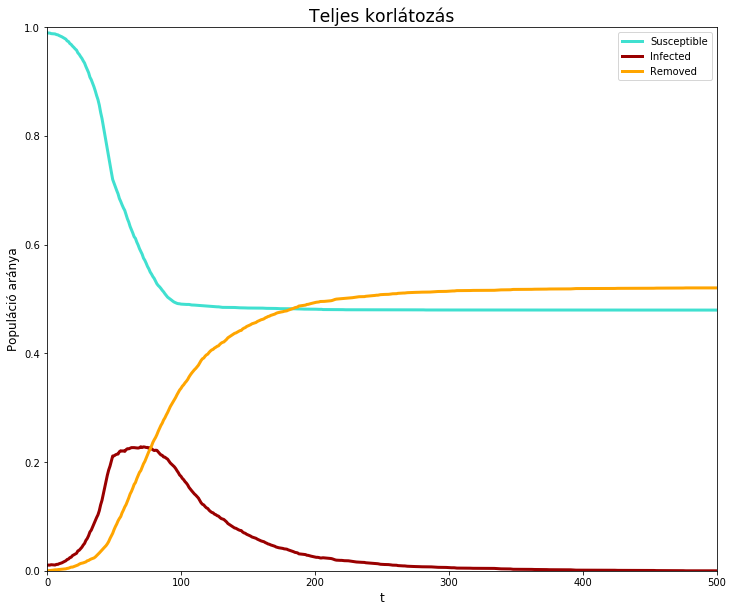

In [56]:
line_plot("full_restriction", "Teljes korlátozás")

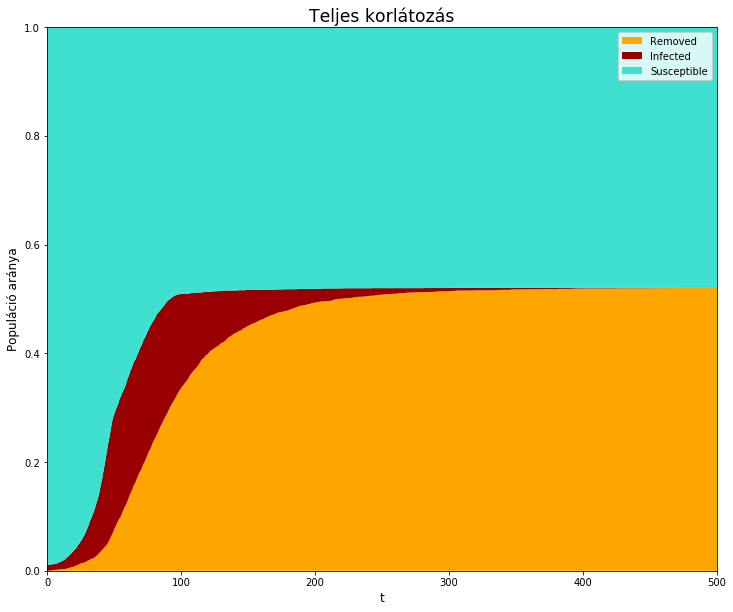

In [57]:
stack_plot("full_restriction", "Teljes korlátozás")

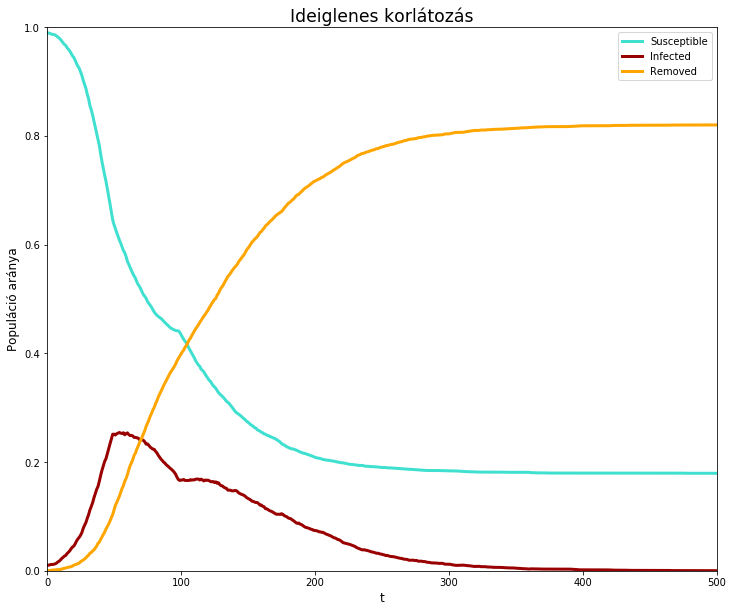

In [58]:
line_plot("temp_restriction", "Ideiglenes korlátozás")

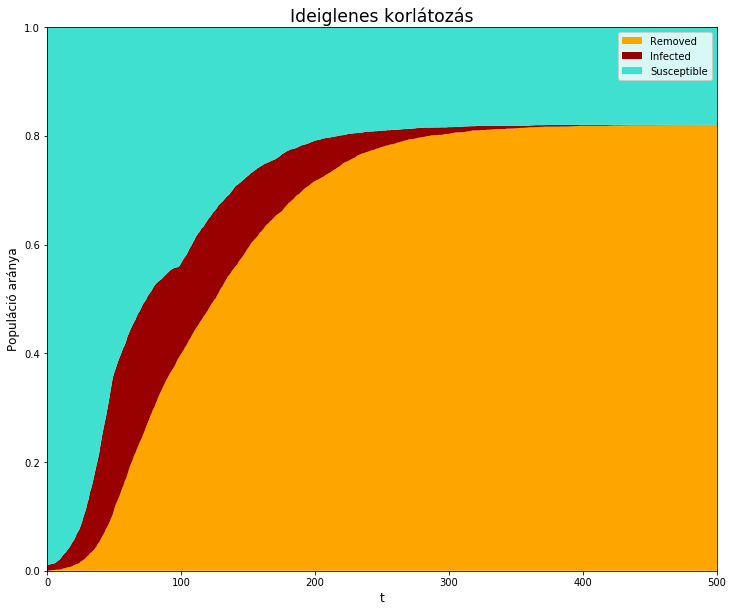

In [59]:
stack_plot("temp_restriction", "Ideiglenes korlátozás")

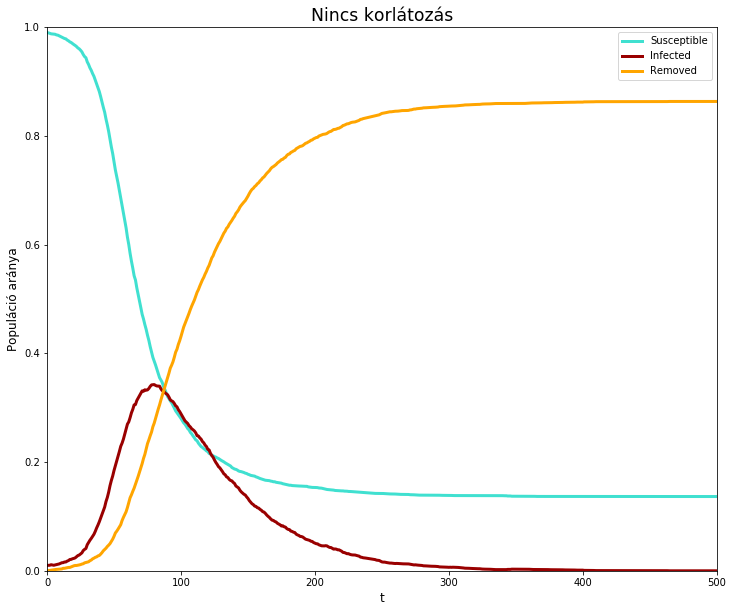

In [60]:
line_plot("no_restriction", "Nincs korlátozás")

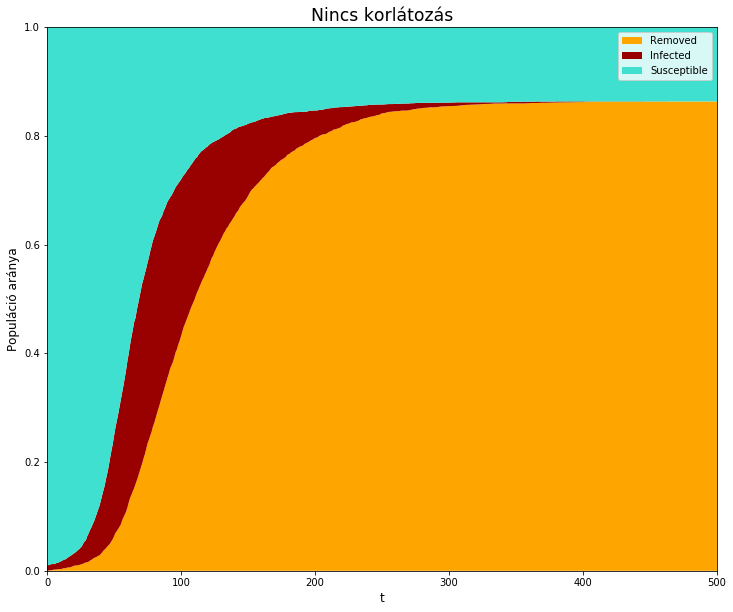

In [61]:
stack_plot("no_restriction", "Nincs korlátozás")

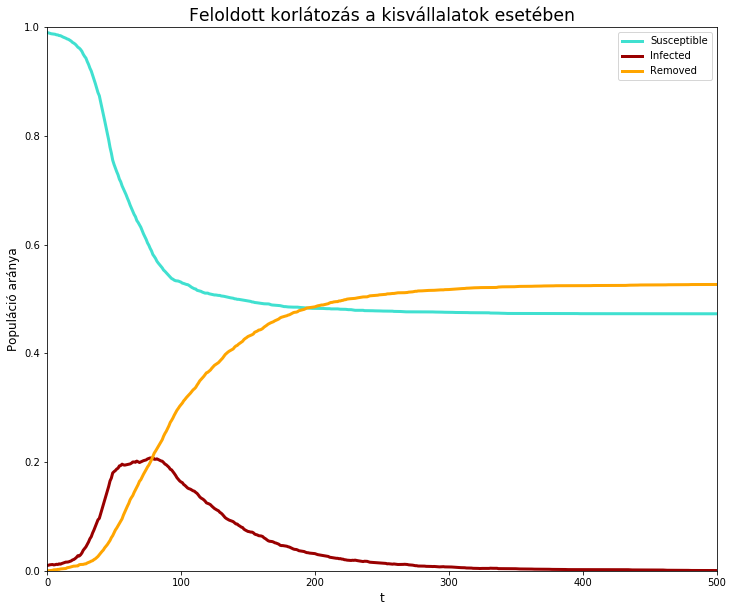

In [62]:
line_plot("only_small_enterprises", "Feloldott korlátozás a kisvállalatok esetében")

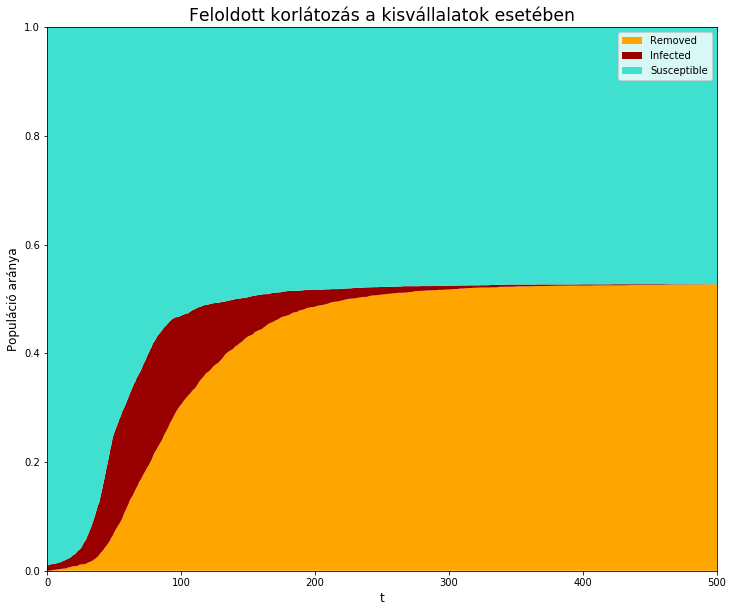

In [63]:
stack_plot("only_small_enterprises", "Feloldott korlátozás a kisvállalatok esetében")

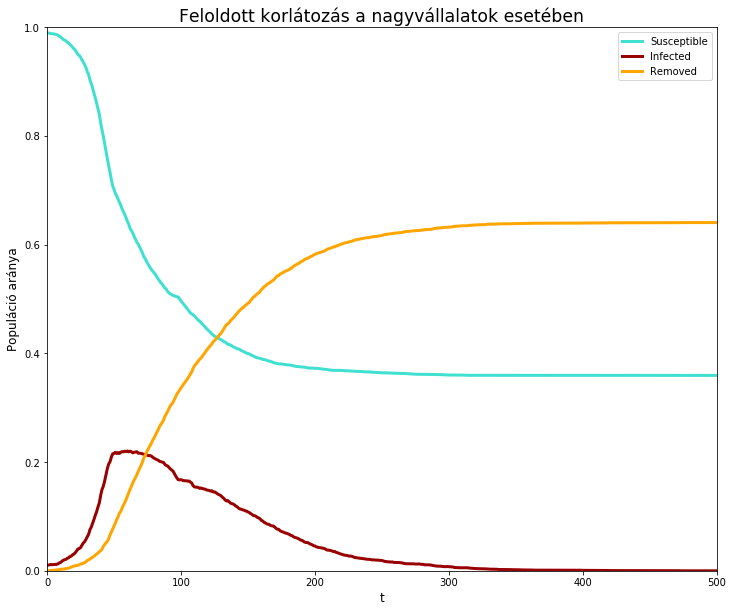

In [64]:
line_plot("only_large_enterprises", "Feloldott korlátozás a nagyvállalatok esetében")

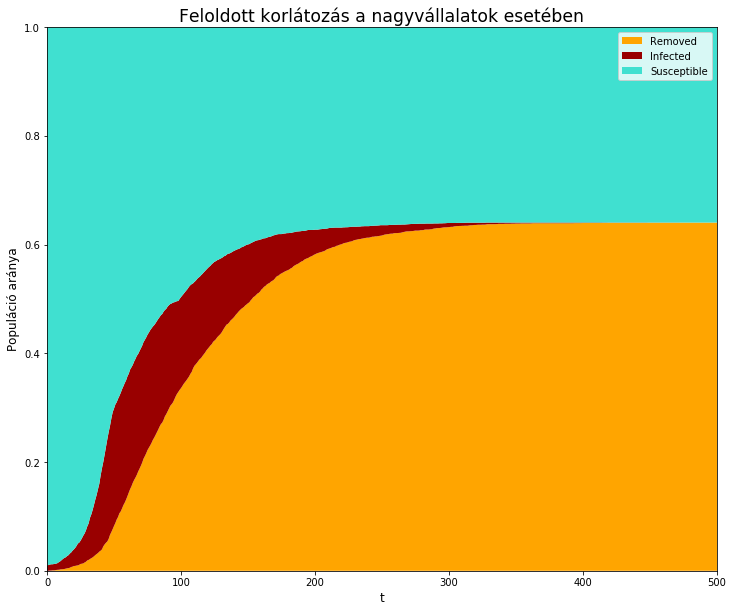

In [65]:
stack_plot("only_large_enterprises", "Feloldott korlátozás a nagyvállalatok esetében")

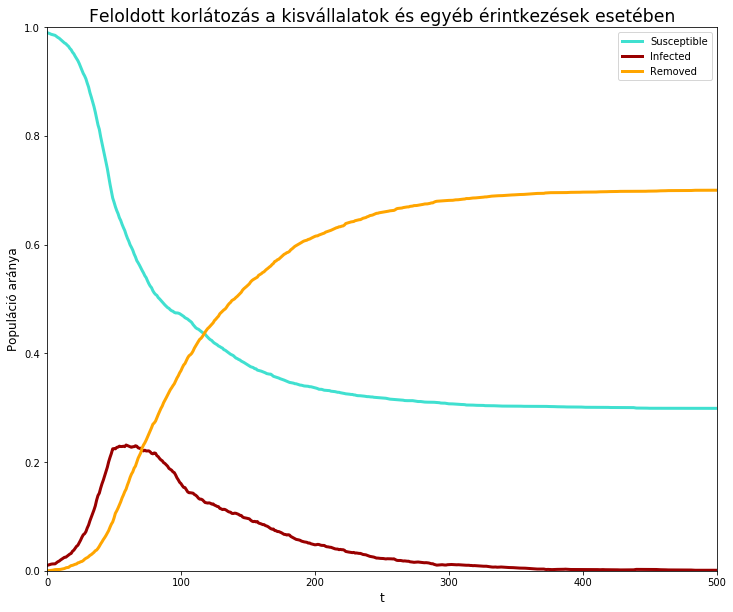

In [66]:
line_plot("no_large_enterprises", "Feloldott korlátozás a kisvállalatok és egyéb érintkezések esetében")

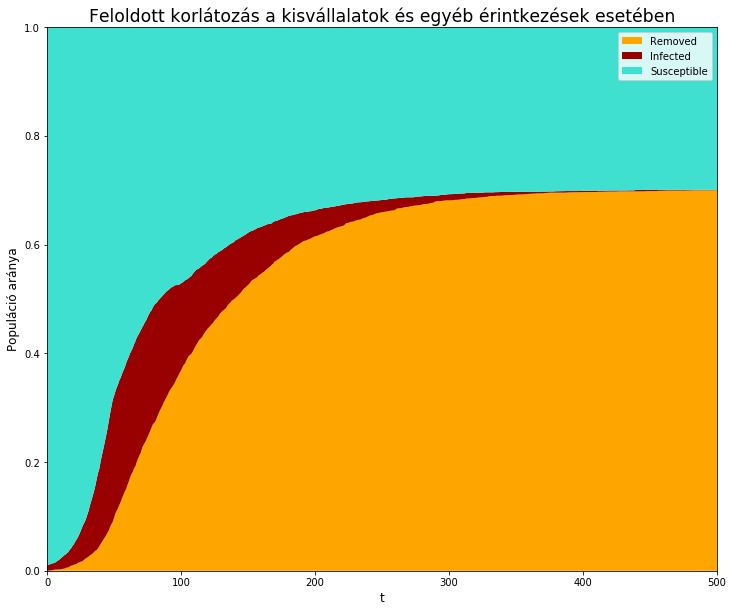

In [67]:
stack_plot("no_large_enterprises", "Feloldott korlátozás a kisvállalatok és egyéb érintkezések esetében")

In [68]:
inf_summary = pd.DataFrame(
    {p: "{}%".format(round(max(trends_dict[p][2]) / 50, 1)) for p in trends_dict.keys()},
    index=["infected"],
).T.sort_values(by="infected")

In [69]:
inf_summary

,infected
full_restriction,52.0%
only_small_enterprises,52.7%
only_large_enterprises,64.1%
no_large_enterprises,70.1%
temp_restriction,82.1%
no_restriction,86.3%


In [50]:
inf_summary.to_csv("inf_summary.csv")